#**Introduction to Convolutional Neural Network (CNN): A Case Study of Brain Tumor Classfication**

In [ ]:
# !unzip /content/archive.zip

In [ ]:
#import the necessary libraries
import torch
# pytorch module that provide neural network functions
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
### Remove unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

##Some functions in the nn module:

###Layers:
- nn.Linear: A fully connected (dense) layer.
- nn.Conv2d: A 2D convolutional layer for image processing.
- nn.MaxPool2d: A 2D max-pooling layer.
- nn.Dropout: A layer for dropout regularization.
- nn.BatchNorm2d: A batch normalization layer.

###Activation Functions:
- nn.ReLU: Rectified Linear Unit activation function.
- nn.Sigmoid: Sigmoid activation function.
- nn.Tanh: Hyperbolic tangent activation function.

###Loss Functions:
- nn.CrossEntropyLoss: Commonly used for multi-class classification tasks.
- nn.MSELoss: Mean squared error loss for regression tasks.

###Other Utilities:
- nn.Sequential: A container for creating a sequence of layers.
- nn.Module: The base class for defining custom neural network modules.

# Data Loading and Augmentation

In [ ]:
data_dir = "/content/data"


In [ ]:
# Data Augmentation and Normalization for training and Normalization for testing

data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



#Assinging the training and testing folder of the data with os path-joiner
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}



#defining the image batch size, initiate image data shuffling and num_workers
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}

#finding class names from the training data folder
class_names = image_datasets['Training'].classes


#Initiating condition for device selection whether it will be using GPU or CPU
device = torchp.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Training Data Visualization

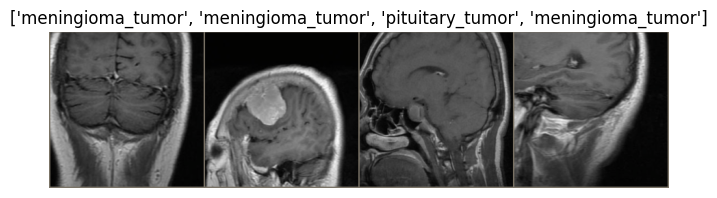

In [ ]:
#Defining the Visualization function

def show_img(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8,5))
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Getting a batch of training data
inputs, classes = next(iter(dataloaders['Training']))

# Making a grid from batch
out = torchvision.utils.make_grid(inputs)

#Let's show them with their titles of class names
show_img(out, title=[class_names[x] for x in classes])

# Train the Model

Let's define the function which we will use to ***train the model***. The input parameters which we will use to for the train function are:

**1. Model (model):**
    
- We will input the pre-trained model in here, with the weights of a benchmark dataset (ImageNet-1K/ CIFAR-100/ CIFAR-10).


**2. Criterion (criterion):**
    
- Criterions are helpful to train a neural network. Given an input and a target, they compute a gradient according to a given loss function.

**3. Optimizer (optimizer):**
    
- Here, the 'Optimizer' function is mostly depended on two input parameters. Those are:
    
    
- Learning rate (lr): The learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.
    
- Momentum (momentum): Momentum is a strong optimization approach that can speed up convergence, minimize oscillations, avoid local minima, and make the optimization process more resistant to noisy gradients.

**4. Scheduler (scheduler):**

- Here, the 'Scheduler' function is mostly depended on three input parameters. Those are:
    
4.1. Optimizer (optimizer_ft): Here we are going to use Stochastic Gradient Descent (SGD) as an optimizer
    
4.2. Step Size (step_size=7)
    
4.3. Gamma Value (gamma) : the gamma parameter defines how far the influence of a single training example reaches, with low values meaning 'far' and high values meaning 'close'.


**5. Number of Epochs (num_epochs)**


In [ ]:
#Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and testing phase
            for phase in ['Training', 'Testing']:
                if phase == 'Training':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'Training'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'Training':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'Training':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'Testing' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
#Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['Testing']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                show_img(inputs.cpu().data[j],title=f'predicted: {class_names[preds[j]]}')
                plt.tight_layout()
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
            model.train(mode=was_training)




# Invoking the Pre-trained Model

<img src='https://open-instruction.com/loading/2021/05/q.png'>

In [ ]:
# Invoking resnet50 model with the weights of the benchmark dataset of ImageNet-1K-Version1,
#ImageNet is the revolutionary contribution of computer vision researchers from Stanford University and other Institutions

model_ft = models.resnet50(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# Setting up the learning rate and momentum
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 112MB/s]


In [ ]:
#Let's find out which device we are currently using, CUDA enabled GPU or CPU?
print(device)

cuda:0


# Start the Training

Let's start the training of the actual model with all the five parameters (model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs)

In [ ]:
num_epochs = 50
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/49
----------
Training Loss: 0.9272 Acc: 0.6446
Testing Loss: 1.2582 Acc: 0.7157

Epoch 1/49
----------
Training Loss: 0.6761 Acc: 0.7603
Testing Loss: 1.4671 Acc: 0.7005

Epoch 2/49
----------
Training Loss: 0.5454 Acc: 0.8084
Testing Loss: 0.8616 Acc: 0.7690

Epoch 3/49
----------
Training Loss: 0.4956 Acc: 0.8321
Testing Loss: 1.4320 Acc: 0.7132

Epoch 4/49
----------
Training Loss: 0.4411 Acc: 0.8467
Testing Loss: 1.4927 Acc: 0.7437

Epoch 5/49
----------
Training Loss: 0.3894 Acc: 0.8613
Testing Loss: 2.8183 Acc: 0.6751

Epoch 6/49
----------
Training Loss: 0.3430 Acc: 0.8774
Testing Loss: 1.2866 Acc: 0.7310

Epoch 7/49
----------
Training Loss: 0.2817 Acc: 0.9021
Testing Loss: 1.2396 Acc: 0.7843

Epoch 8/49
----------
Training Loss: 0.2231 Acc: 0.9258
Testing Loss: 1.1042 Acc: 0.7843

Epoch 9/49
----------
Training Loss: 0.2256 Acc: 0.9303
Testing Loss: 1.1856 Acc: 0.7843

Epoch 10/49
----------
Training Loss: 0.2205 Acc: 0.9303
Testing Loss: 1.0472 Acc: 0.7995

Epoch 11/

<Figure size 640x480 with 0 Axes>

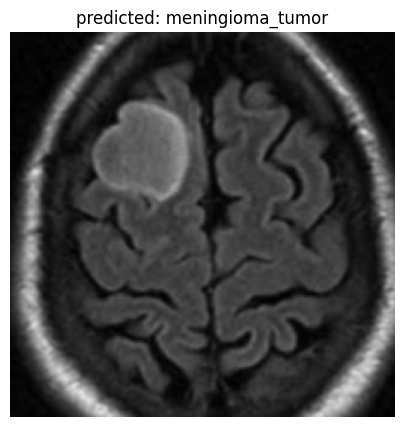

<Figure size 640x480 with 0 Axes>

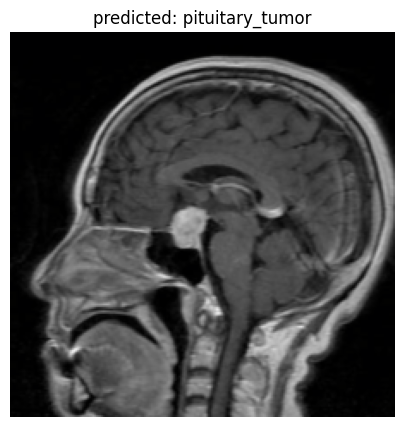

<Figure size 640x480 with 0 Axes>

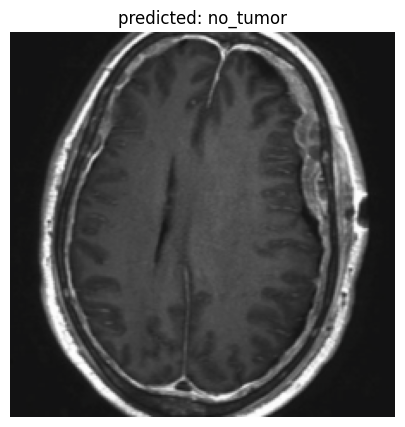

<Figure size 640x480 with 0 Axes>

In [ ]:
#Let's start visualization of the model with prediction of the classes

visualize_model(model_ft,3)

In [ ]:
#Let's start visualization of the model with prediction of the classes.
#Inputs: model (model_ft) and path of the testing image (img_path)

def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['Testing'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        show_img(img.cpu().data[0], f'Predicted: {class_names[preds[0]]}')
        plt.tight_layout()

        model.train(mode=was_training)

**Testing and Predicting**

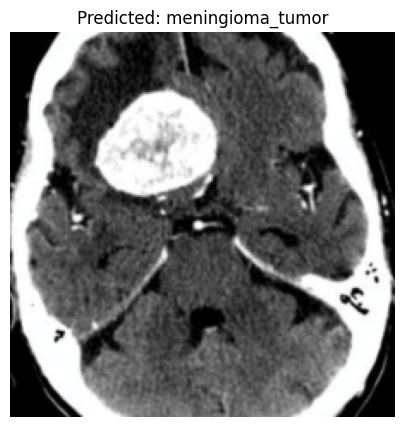

<Figure size 640x480 with 0 Axes>

In [ ]:
#Make an input of image from testing folder, containing an Image of Meningioma Tumor

visualize_model_predictions(
    model_ft,
    img_path='/content/data/Testing/meningioma_tumor/image(124).jpg'
)

plt.ioff()
plt.tight_layout()

plt.show()

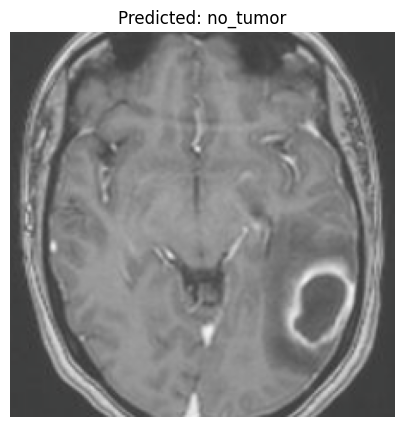

<Figure size 640x480 with 0 Axes>

In [ ]:
#Make an input of image from testing folder, containing an Image of Glioma Tumor

visualize_model_predictions(
    model_ft,
    img_path='/content/data/Testing/glioma_tumor/image(55).jpg'
)

plt.ioff()
plt.show()

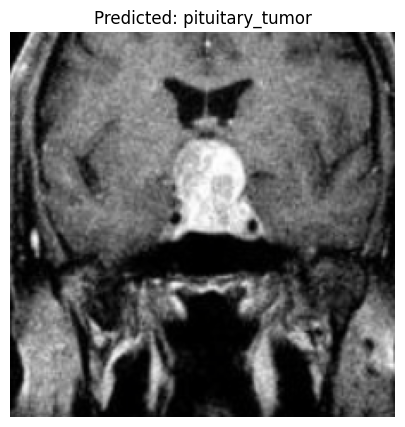

<Figure size 640x480 with 0 Axes>

In [ ]:
#Make an input of image from testing folder, containing an Image of Pituitary Tumor

visualize_model_predictions(
    model_ft,
    img_path='/content/data/Testing/pituitary_tumor/image(35).jpg'
)

plt.ioff()
plt.show()

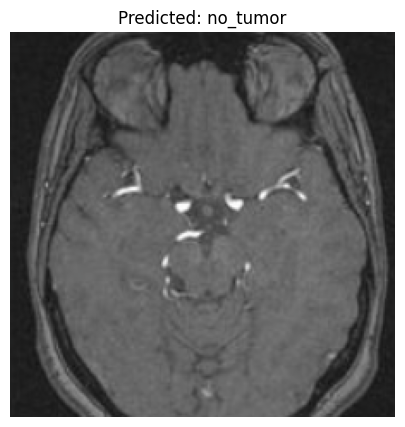

<Figure size 640x480 with 0 Axes>

In [ ]:
#Make an input of image from testing folder, containing an Image of No Tumor

visualize_model_predictions(
    model_ft,
    img_path='/content/data/Testing/no_tumor/image(27).jpg'
)

plt.ioff()
plt.show()